Bayesian GPLVM
--
This notebook shows how to use the Bayesian GPLVM model.

In [1]:
from __future__ import print_function
import gpflow
from gpflow import ekernels
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

### Data
Install the oil dataset.

In [2]:
data = pods.datasets.oil_100()
Y = data['X']
print('Number of points X Number of dimensions', Y.shape)
data['citation']

Number of points X Number of dimensions (100, 12)


'Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593'

### Model construction
Create Bayesian GPLVM model using additive kernel.

In [9]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = ekernels.Add([ekernels.RBF(3, ARD=True, active_dims=slice(0,3)),
                  ekernels.Linear(2, ARD=False, active_dims=slice(3,5))])
else:
    k = ekernels.Add([ekernels.RBF(3, ARD=True, active_dims=[0,1,2]),
                  ekernels.Linear(2, ARD=False, active_dims=[3, 4])])
    
m = gpflow.gplvm.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01
m.optimize(disp=True, maxiter=100)

/home/mqbssaby/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      fun: array([-164.60377526])
 hess_inv: <1106x1106 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.30696395, -0.48415864,  0.9047818 , ...,  0.04990779,
       -0.02856837, -0.11484141])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 104
      nit: 101
   status: 1
  success: False
        x: array([-6.8716675 ,  4.60058366,  1.54838159, ..., -4.29151193,
       -1.68602311, -1.46621623])

### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

kern.linear.variance transform:+ve prior:None
[ 0.00103721]
kern.rbf.lengthscales transform:+ve prior:None
[ 4.61058051  1.7411426   4.53975876]
kern.rbf.variance transform:+ve prior:None
[ 1.015205]
[ 0.21853513  0.57868541  0.22194435]


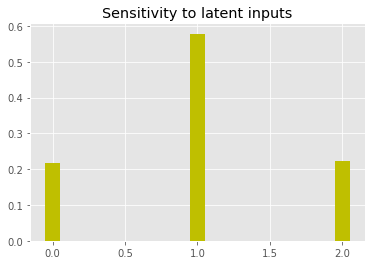

In [10]:
kern = m.kern.kern_list[0]
sens = np.sqrt(kern.variance.value)/kern.lengthscales.value
print(m.kern)
print(sens)
fig, ax = plt.subplots()
ax.bar(np.arange(len(kern.lengthscales.value)) , sens, 0.1, color='y')
ax.set_title('Sensitivity to latent inputs')

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

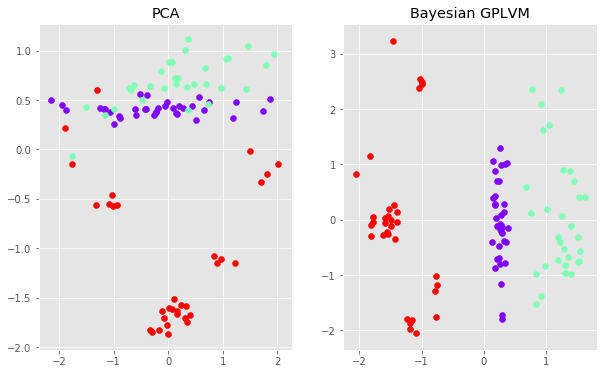

In [11]:
XPCAplot = gpflow.gplvm.PCA_reduce(data['X'], 2)
f, ax = plt.subplots(1,2, figsize=(10,6))
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i,0], XPCAplot[labels==i,1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(m.X_mean.value[labels==i,1], m.X_mean.value[labels==i,2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')
    